In [1]:
#import necessary packages
import os
import sys
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#put in drive path
drive_path = 'e:/'

In [3]:
#import allen institute stuff
from allensdk.core.brain_observatory_cache import BrainObservatoryCache
import pprint
boc = BrainObservatoryCache(manifest_file="E:\BrainObservatory\manifest.json")

#stimulus specific analysis
from allensdk.brain_observatory.natural_scenes import NaturalScenes

In [4]:
all_expts = boc.get_ophys_experiments()
all_expts = pd.DataFrame(all_expts)

In [5]:
# get session id for known experiment container & session type
all_expts[(all_expts.experiment_container_id==511506664)&(all_expts.session_type=='three_session_B')].id.values[0]

500947031

In [6]:
#user input of experiment container, imaging session and, cell ID to look at 
cont_id = 511506664
img_sess = 500947031
cell_of_interest = 517402096

In [7]:
#assigning imaging session to a variable
session_id = all_expts[(all_expts.experiment_container_id==cont_id)&(all_expts.session_type=='three_session_B')].id.values[0]

In [8]:
#get data for a single experiment session
data_set = boc.get_ophys_experiment_data(ophys_experiment_id = img_sess)

In [20]:
#get stimulus information
ns = NaturalScenes(data_set)
images = data_set.get_stimulus_template('natural_scenes')

0      2.73179
1      2.25469
2      6.71767
3      50.3686
4      16.9881
5      13.2809
6      11.0378
7      2.84688
8       5.5442
9       1.9885
10     4.30989
11     5.47956
12     3.19432
13     5.38247
14     5.45606
15     86.3533
16     8.60703
17     10.9254
18      16.823
19     1.54478
20     2.64026
21     1.66816
22     9.41354
23     2.94382
24     10.7085
25     1.88255
26     2.18668
27     19.7565
28      1.1911
29     5.86599
        ...   
91     2.86933
92     8.87958
93     2.25148
94     4.38225
95     3.22203
96     12.7025
97     14.2967
98     31.7474
99     3.34769
100    3.64403
101    14.1832
102    3.71536
103    3.06379
104    3.41635
105    59.9216
106    20.7181
107      3.587
108    4.32086
109    38.9235
110    38.4161
111    4.25397
112    1.99376
113     3.6642
114    4.68974
115    5.55734
116    6.75728
117    26.8505
118    7.33323
119    18.7585
120    41.0038
Name: peak_dff_ns, dtype: object

In [ ]:
responsive_cells = ns.peak[ns.peak.peak_dff_ns>=5].cell_specimen_id.values
len(responsive_cells)
ns.peak.peak_dff_ns

In [10]:
#get cell index
cell_idx = data_set.get_cell_specimen_indices([cell_of_interest])[0]

In [11]:
#get stimulus template (aka stimulus frames) for images, movies or locally sparse noise
ns_template = data_set.get_stimulus_template(stimulus_name='natural_scenes')
ns_template.shape
#get stimulus table
stim_table = data_set.get_stimulus_table('natural_scenes')

,frame,start,end
0,65,16126,16133
1,46,16133,16140
2,64,16141,16148
3,12,16148,16155
4,43,16156,16163


In [13]:
cell_specimen_ids = data_set.get_cell_specimen_ids()
cell_specimen_idx = data_set.get_cell_specimen_indices(cell_specimen_ids)
timestamps,traces = data_set.get_dff_traces()

In [16]:
frames_arr = np.empty(0)
images_arr = np.empty(0)
for sweep in range(len(stim_table)):
    start = stim_table.iloc[sweep].start
    end = stim_table.iloc[sweep].end
    frames = np.arange(start,end)
    frames_arr = np.hstack((frames_arr,frames))
    image = stim_table.iloc[sweep].frame
    for i in range(len(frames)):
        images_arr = np.hstack((images_arr,image))

In [17]:
traces_arr = np.empty((traces.shape[0],frames_arr.shape[0]))
for t in range(traces.shape[0]): 
    trace = np.empty(0)
    for sweep in range(len(stim_table)):
        start = stim_table.iloc[sweep].start
        end = stim_table.iloc[sweep].end
        tmp = traces[t,start:end]
        trace = np.hstack((trace,tmp))
    traces_arr[t,:] = trace

In [18]:
def plot_mean_image(cell_specimen_id,ns,images,images_arr,traces_arr,thresh=0.3,weighted=False):
    cell_idx = np.where(ns.cell_id==cell_specimen_id)[0][0]
    thresh_inds = np.where(traces_arr[cell_idx,:]>=thresh)[0]
    thresh_inds = thresh_inds - 6
    thresh_vals = traces_arr[cell_idx][thresh_inds]
    thresh_images = images_arr[thresh_inds]
    n_images = len(np.unique(thresh_images))
    img_stack = np.empty((thresh_images.shape[0],images[0,:,:].shape[0],images[0,:,:].shape[1]))
    for i,img in enumerate(thresh_images):
        img_stack[i,:,:] = images[img,:,:]
    if weighted: 
        mean_image = np.average(img_stack,axis=0,weights=thresh_vals)
    else: 
        mean_image = np.mean(img_stack,axis=0)
    fig,ax=plt.subplots()
    ax.imshow(mean_image,cmap='gray')
    if weighted:
        ax.set_title('cell '+str(cell_specimen_id)+', weighted mean of '+str(n_images)+' images')
    else:
        ax.set_title('cell '+str(cell_specimen_id)+', mean of '+str(n_images)+' images')

C:\Users\kater\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:10: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


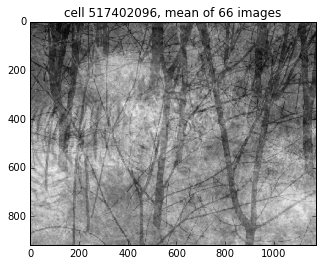

In [21]:
plot_mean_image(cell_of_interest,ns,images,images_arr,traces_arr,thresh=0.3,weighted=False)